In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
from pathlib import Path
module_path = str(Path.cwd().parents[0])
if module_path not in sys.path:
    sys.path.append(module_path)

In [3]:
import time
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from benchmarking.data import dataset_loaders, DatasetGroup
from hnne.v2_plotter import format_time, format_count, plot_projection_grid, plot_v2_nested_2d, plot_layout_level_2d
from hnne.hierarchical_projection import multi_step_projection
from hnne.projector import HNNE

# Run on downloaded datasets

### Dowload all hnne datasets as used in the paper as tar file (https://bwsyncandshare.kit.edu/s/Bp4gwZ4xcgj7otG). see the example loader below

In [6]:
data_path = Path(module_path, 'hnne_datasets')
## Load small, medium or large datasets, see ./hnne/benchmarking/data.py
loaders = dataset_loaders(dataset_group=DatasetGroup.medium)
loaders.keys()

dict_keys(['imagenet_test', 'cifar_10', 'bbt', 'buffy'])

In [7]:
random_state=42
dataset_name = 'bbt' #'cifar_10'
data, targets = loaders[dataset_name](data_path)
prefered_num_clust = len(set(targets))
prefered_num_clust

5

## run FINCH

In [8]:

partitions, requested_partition, partition_sizes, partition_labels = HNNE(random_state=random_state, prefered_num_clust=None, metric='cosine').fit_only_hierarchy(data)
finch_output = [partitions,requested_partition, partition_sizes, partition_labels]

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [31]:
partition_sizes

[49316, 11032, 2537, 423, 39, 8]

In [25]:
from hnne.v2_utils import _nearest_level_geq_coarsest, choose_v2_level_block

In [37]:

sizes= np.array(partition_sizes)
s = _nearest_level_geq_coarsest(sizes, 10)
s

5

## h-NNE v1 vs h-NNE v2

In [53]:
def wrapper(data,
            finch_output,
            preliminary_embedding='pca',
            # v2 knobs 
            hnne_version="v2",
            prefered_num_clust=None,
            v2_size_threshold=None,
            start_cluster_view='auto',
            random_state=42):
    
    partitions, requested_partition, partition_sizes, partition_labels = finch_output 
    
    projection, _, _, _, _, _, _, _, v2_layout = multi_step_projection(
    data=data,
    partitions=partitions,
    partition_labels=partition_labels,
    radius=0.4,
    ann_threshold=20000,
    dim=2,
    partition_sizes=partition_sizes,
    preliminary_embedding=preliminary_embedding,
    random_state=random_state,
    hnne_version=hnne_version,
    prefered_num_clust=prefered_num_clust,
    requested_partition=requested_partition,    
    v2_size_threshold=v2_size_threshold,
    start_cluster_view=start_cluster_view,  
    verbose=False,
    )
    return projection, v2_layout

In [15]:
%%time
hnne_v1, _= wrapper(data,finch_output, hnne_version='v1', prefered_num_clust=None, start_cluster_view=None, v2_size_threshold=None)


CPU times: user 1min 6s, sys: 25.2 s, total: 1min 31s
Wall time: 11.4 s


In [42]:
%%time
hnne_v2_auto, _ = wrapper(data,finch_output, hnne_version='v2', prefered_num_clust=None, start_cluster_view='auto', v2_size_threshold=None)

CPU times: user 1min, sys: 23.8 s, total: 1min 24s
Wall time: 11.8 s


In [46]:
%%time
hnne_v2_level_500, _= wrapper(data,finch_output, hnne_version='v2', prefered_num_clust=None, start_cluster_view=500, v2_size_threshold=None)

CPU times: user 1min 4s, sys: 21.1 s, total: 1min 25s
Wall time: 11.4 s


In [47]:
%%time
hnne_v2_level_3000_start, _ = wrapper(data,finch_output, hnne_version='v2', prefered_num_clust=None, start_cluster_view=3000, v2_size_threshold=None)

CPU times: user 1min 12s, sys: 22 s, total: 1min 33s
Wall time: 22.5 s


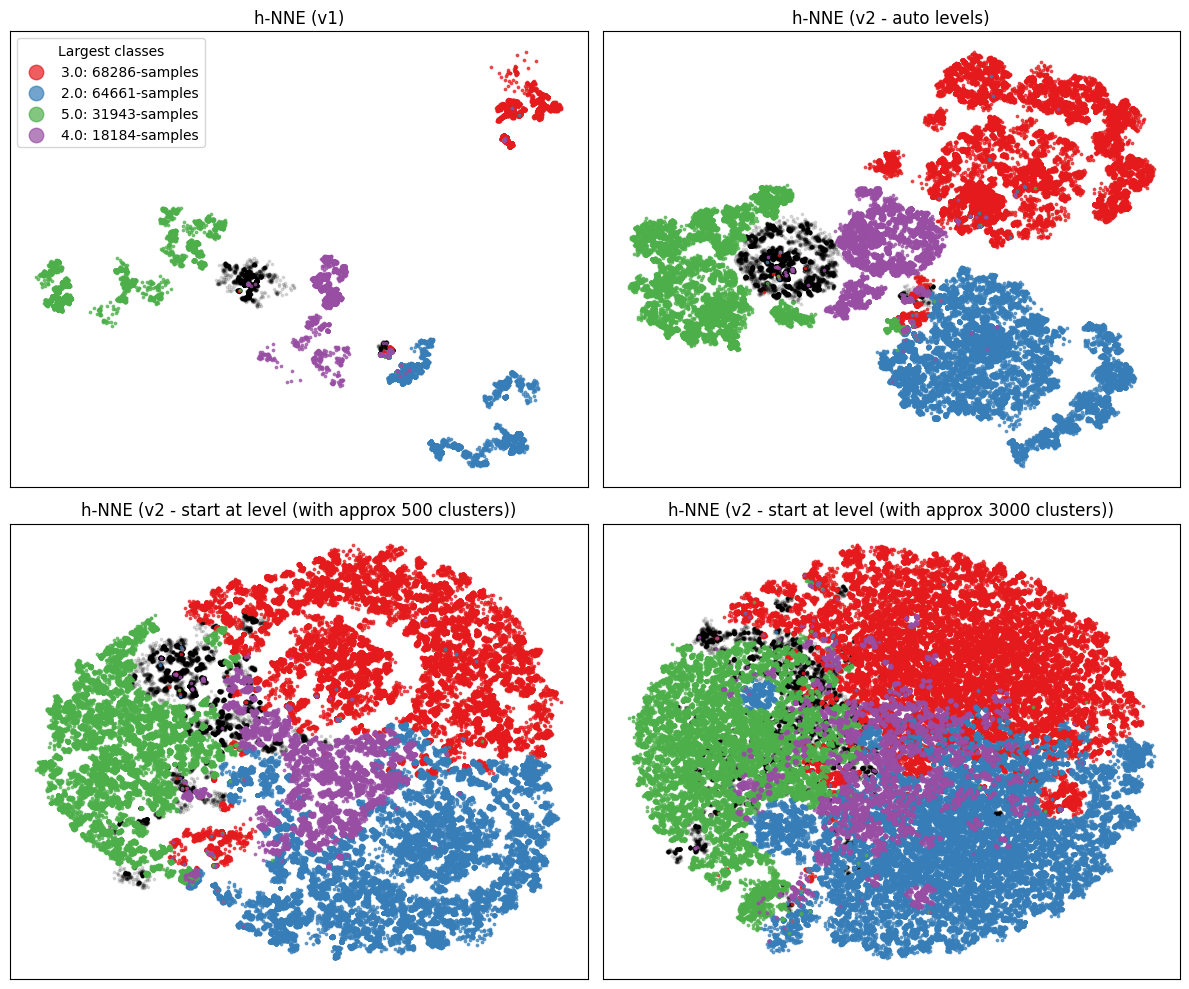

In [48]:
plt = plot_projection_grid(
    [hnne_v1, hnne_v2_auto, hnne_v2_level_500, hnne_v2_level_3000_start],
    labels=targets, #partitions[:, -2],  # or None
    titles=("h-NNE (v1)", "h-NNE (v2 - auto levels)", "h-NNE (v2 - start at level (with approx 500 clusters))", "h-NNE (v2 - start at level (with approx 3000 clusters))"),
    point_size=3,
    other_color='#000000',
    equal_aspect=False,        # set True if projection scales are comparable
    show=False
)
plt.show()

## tmp plots for paper

In [51]:
%%time
hnne_v2_large_level_auto_f, v2_layout_auto = wrapper(data,finch_output, preliminary_embedding='pca', hnne_version='v2', prefered_num_clust=None, start_cluster_view='auto', v2_size_threshold=None)

CPU times: user 1min 8s, sys: 19.5 s, total: 1min 27s
Wall time: 12.5 s


In [52]:
partition_sizes

[49316, 11032, 2537, 423, 39, 8]

In [83]:
levels_in_layout, clusters_levels = np.unique([item[0] for item in v2_layout_auto.keys()], return_counts=True)
sel_lvl = [i for i, e in enumerate(partition_sizes) if e in clusters_levels]
print(f'levels_in_layout:{levels_in_layout} - clusters_levels {clusters_levels} - sel_lvl: {sel_lvl}')

levels_in_layout:[0 1] - clusters_levels [423  39] - sel_lvl: [3, 4]


In [88]:
parent_level=levels_in_layout[-1]
child_levels=[levels_in_layout[0]]
sel_part = partitions[:, sel_lvl]
num_child = [len(set(sel_part[:, j])) for j in child_levels]
num_child = '_'.join(map(str,num_child))
name = str(f'level_{len(set(sel_part[:, parent_level]))}_{num_child}')


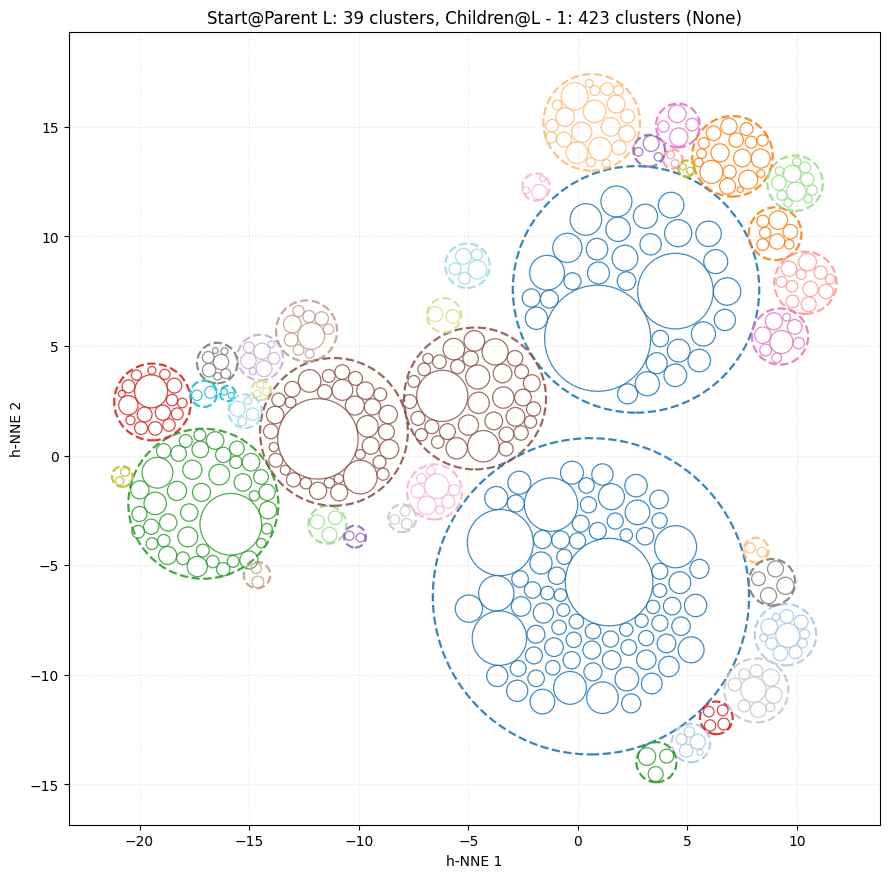

In [89]:

plt = plot_v2_nested_2d(
    v2_layout_auto,
    sel_part,
    parent_level=parent_level,
    child_levels=child_levels,
    draw_parent_labels=False,
    draw_child_labels=False,
    time_elapsed=None
)
#plt.savefig(f"./visualization_imgs/{name}.jpg")
plt.show()


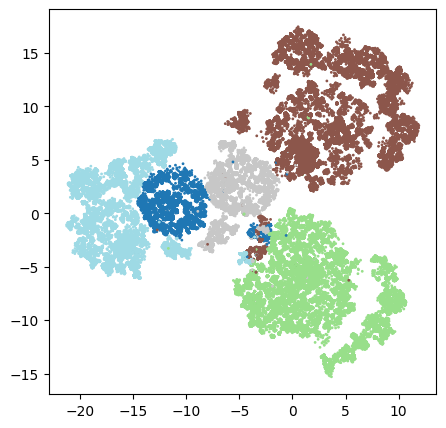

In [87]:
ig, ax = plt.subplots(1, 1, figsize=(5,5))
ax.scatter(*hnne_v2_large_level_auto_f.T, s=1, c=targets, cmap='tab20')
plt.show()